In [13]:
import yaml
import numpy as np
import matplotlib.pyplot as plt
import torch

from os.path import join as ospj
from IMPA.checkpoint import CheckpointIO
from IMPA.solver import Solver
from IMPA.dataset.data_utils import CustomTransform

**Util functions**

In [40]:
def parse_yaml(path):
    """
    Read configuration yaml file and parse 

    Args:
        path (str): path to the .yaml file with the configuration of the experiment
    
    """
    with open(path, "r") as stream:
        config = yaml.safe_load(stream)
    return config["args"]

class Args(dict):
    """
    Wrapper around a dictionary to make its keys callable  

    Args:
        path (str): path to the .yaml file with the configuration of the experiment
    
    """
    def __init__(self, *args, **kwargs):
        super(Args, self).__init__(*args, **kwargs)
        self.__dict__ = self
        
def tensor_to_np_image(t, normalized=True):
    """
    Transform a tensor to a plottable np array  

    Args:
        t (torch.tensor): tensor to convert to numpy
        normalized (bool): if the image of input is between -1 and 1
    """
    if normalized:
        t = ((t+1)/2).clip(0,1)
    return t.cpu().detach().squeeze().permute(1, 2, 0)

**Function to initialize IMPA**

In [3]:
def initialize_IMPA(path,  
                    checkpoint):
    """Function to initialize impa model 

    Args:
        path (str): path to the .yaml file with the configuration of the experiment
        number (int): the number of the iteration to use
        checkpoint (str): the checkpoint directory
    """
    
    # Pick a configuration  
    args_IMPA = Args(parse_yaml(path))

    # Initialize IMPA solver 
    solver_IMPA = Solver(args_IMPA)

    # The networks to load 
    to_load = {'generator': solver_IMPA.nets.generator,
                'mapping_network': solver_IMPA.nets.mapping_network, 
                'style_encoder': solver_IMPA.nets.style_encoder, 
                'discriminator': solver_IMPA.nets.discriminator}
    
    print(f'Loading {[key for key in to_load]}')

    # Manually set checkpoints
    ckptios = [
        CheckpointIO(ospj(checkpoint, 'nets.ckpt'), data_parallel=True, **to_load)] 
    solver_IMPA.ckptios = ckptios
    
    # Load checkpoints 
    solver_IMPA._load_checkpoint(0)
    return solver_IMPA

Function to transform cells with IMPA

In [71]:
def perform_transformation(solver, 
                            X, 
                            y, 
                            device):
    """Given input images, we use the model to perform transformations and predict on the data

    Args:
        solver (Solver): solver object 
        model_name (str): name of the model to use  
        X (torch.Tensor): the images submitted to transformation  
        y (torch.Tensor): 1D tensor with condition labels included 
        device (str): device used for the transformation

    Returns:
        torch.Tensor: transformed images
    """
    z = torch.randn(X.shape[0], 100, solver.args.z_dimension).mean(1).to(device)

    # Embedding of the labels from RDKit
    z_emb = solver.embedding_matrix(y).view(X.shape[0], -1)

    if solver.args.stochastic:
        z_emb = torch.cat([z_emb, z], dim=1)

    # Collect the mapping of the label by the model 
    s_trg = solver.nets.mapping_network(z_emb)

    # Generate the image 
    _, x_fake = solver.nets.generator(X, s_trg)

    return x_fake

**Initialize model and run transformations**

In [72]:
path_to_config = "../training_configs/bbbc021_six_config.yaml"
path_to_ckpt = "../checkpoints/bbbc021_six"
path_to_example_cells = ""

In [73]:
transform = CustomTransform(augment=False, normalize=True)

In [74]:
model = initialize_IMPA(path_to_config,  
                        path_to_ckpt)

Lodading the data...
Loading images...
['AZ138' 'AZ258' 'DMSO' 'cytochalasin B' 'taxol' 'vincristine']
6
Training with 6 mols
Successfully loaded the data
Solver loaded with parameters:
 {'img_size': 96, 'latent_dim': 160, 'hidden_dim': 512, 'style_dim': 64, 'stochastic': True, 'z_dimension': 16, 'dim_in': 64, 'lambda_reg': 1, 'lambda_cyc': 1, 'lambda_sty': 1, 'lambda_ds': 1, 'total_iters': 100000, 'ds_iter': 100000, 'resume_iter': 0, 'batch_size': 32, 'val_batch_size': 20, 'lr': 0.0001, 'f_lr': 0.0001, 'beta1': 0, 'beta2': 0.99, 'weight_decay': 0.0001, 'num_outs_per_domain': 10, 'single_style': True, 'ood_set': None, 'mol_list': ['AZ138', 'AZ258', 'cytochalasin B', 'DMSO', 'taxol', 'vincristine'], 'balanced': True, 'trainable_emb': False, 'dataset_name': 'bbbc021', 'n_channels': 3, 'mode': 'train', 'num_workers': 6, 'seed': 42, 'image_path': '../project_folder/datasets/bbbc021_six', 'data_index_path': '../project_folder/datasets/bbbc021_six/metadata/bbbc021_df_six.csv', 'embedding_pat

In [75]:
# Read cell dataset 
cells = np.load("./simple_dmso_dataset/simple_dmso_dataset.npy")

In [76]:
transform_dict = {"DMSO": [],
                  "AZ138": [],
                  "AZ258": [],
                  "cytochalasin B": [],
                  "taxol": [], 
                  "vincristine": []}

for cell in cells:
    cell_tensor = torch.from_numpy(cell).permute(2, 0, 1).unsqueeze(0).float().to(model.device)
    cell_tensor = transform(cell_tensor)
    transform_dict["DMSO"].append(tensor_to_np_image(cell_tensor))
    for mol_id, mol_name in model.id2mol.items():
        if mol_name != "DMSO":
            transformed_cell = perform_transformation(model, 
                                                        cell_tensor, 
                                                        torch.tensor([mol_id]).unsqueeze(0).to(model.device), 
                                                        device=model.device)
            transform_dict[mol_name].append(tensor_to_np_image(transformed_cell))

In [77]:
transform_dict = {key: torch.stack(val, dim=0) for key, val in transform_dict.items()}

DMSO


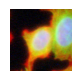

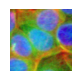

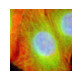

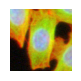

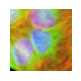

AZ138


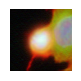

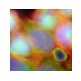

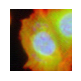

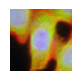

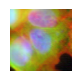

AZ258


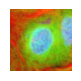

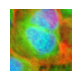

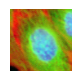

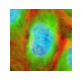

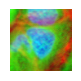

cytochalasin B


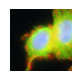

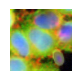

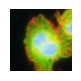

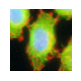

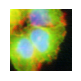

taxol


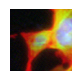

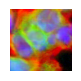

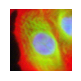

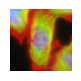

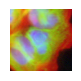

vincristine


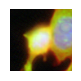

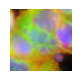

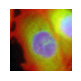

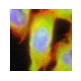

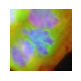

In [78]:
for mol in transform_dict:
    print(mol)
    for i in range(5):
        plt.figure(figsize=(0.8, 0.8))
        plt.imshow(transform_dict[mol][i])
        plt.axis("off")
        plt.show()